# Tarea Semanal 7: Primeras nociones de estimación espectral: Ancho de banda de señales.
## Magdalena Noé
En esta tarea se analizaran 3 señales:
- Electrocardiograma (ECG): Registrado durante una prueba de esfuerzo.
- Pletismografía (PPG). Registrada en reposo de un estudiante de la materia que ha donado su registro para esta actividad.
- Audio. Tres registros en los que el profesor pronuncia una frase, y otros dos en los que se silba una melodía muy conocida.

El analisis a realizar en dichas señales sera una estimación de ancho de banda y de la densidad espectral de potencia (PSD) mediante alguno de los métodos vistos en clase (Periodograma ventaneado, Welch, Blackman-Tukey).

- periodogram() Estimate power spectral density using a periodogram.
- welch()       Estimate power spectral density using Welch's method.
- lombscargle()  Compute the generalized Lomb-Scargle periodogram.


## Bonus:

💎 Proponga algún tipo de señal que no haya sido analizada y repita el análisis. No olvide explicar su origen y cómo fue digitalizada.

### Librerías

In [1]:
import matplotlib.pyplot as plt
from numpy.fft import fft #Para poder escribir fft() en vez de numpy.fft.fft()
import numpy as np
from scipy import signal as sig
from scipy import integrate
import scipy.io as sio
from scipy.io.wavfile import write
import pandas as pd # Para las tablas

## Primera lectura de las señales

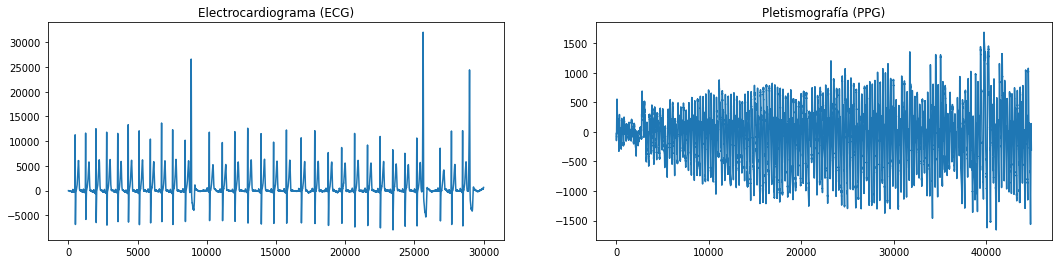

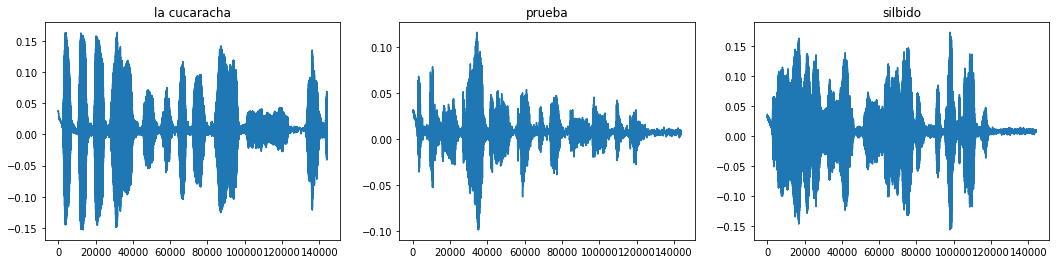

In [2]:
ecg_one_lead = np.load('signals_ts7\ecg_sin_ruido.npy')
fs_ecg = 1000 # Hz

ppg = np.load('signals_ts7\ppg_sin_ruido.npy')
fs_ppg = 400 # Hz

plt.figure(figsize=(18, 4))
plt.subplot(1,2,1); plt.plot(ecg_one_lead); plt.title("Electrocardiograma (ECG)")
plt.subplot(1,2,2); plt.plot(ppg); plt.title("Pletismografía (PPG)")
plt.show()

fs_audio_A, wav_data_A = sio.wavfile.read('signals_ts7\la cucaracha.wav')
fs_audio_B, wav_data_B = sio.wavfile.read('signals_ts7\prueba psd.wav')
fs_audio_C, wav_data_C = sio.wavfile.read('signals_ts7\silbido.wav')

arr_fs_audios = [fs_audio_A, fs_audio_B, fs_audio_C]
arr_wav_data = [wav_data_A, wav_data_B, wav_data_C]

plt.figure(figsize=(18, 4))
plt.subplot(1,3,1); plt.plot(wav_data_A); plt.title("la cucaracha")
plt.subplot(1,3,2); plt.plot(wav_data_B); plt.title("prueba")
plt.subplot(1,3,3); plt.plot(wav_data_C); plt.title("silbido")
plt.show()

## Análisis de las señales
### Densidad espectral de potencia (PSD)

Para obtener la PSD se utiliza la funcion periodogram.

- periodogram() Estimate power spectral density using a periodogram.
    - x: array_like
    Time series of measurement values
    - fs: float, optional
    Sampling frequency of the x time series. Defaults to 1.0.

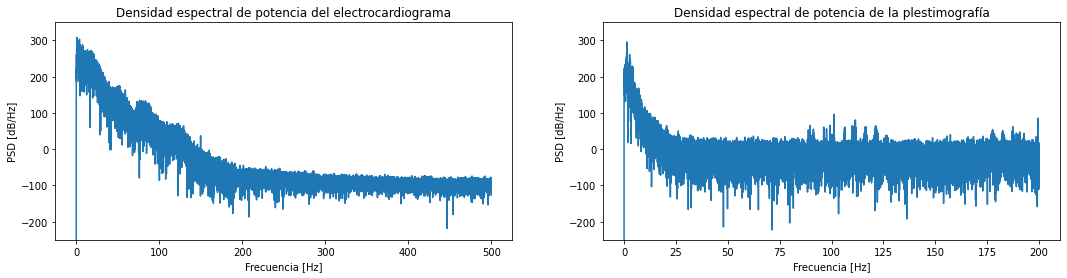

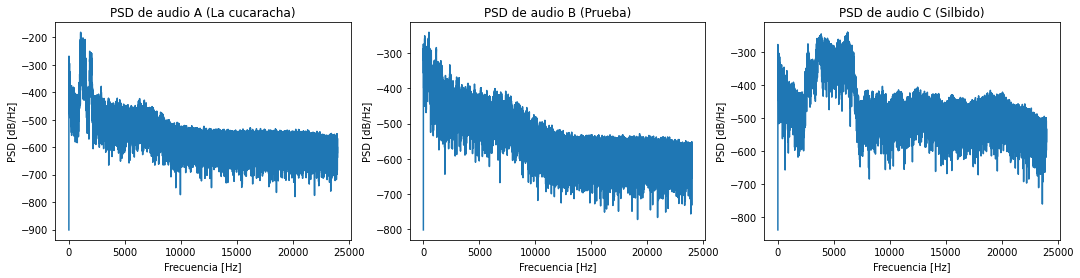

In [14]:
ff_ecg, psd_ecg = sig.periodogram(ecg_one_lead, fs=fs_ecg)
psd_ecg_dB = 20*np.log(psd_ecg)

ff_ppg, psd_ppg = sig.periodogram(ppg, fs=fs_ppg)
psd_ppg_dB = 20*np.log(psd_ppg)

plt.figure(figsize=(18, 4))
plt.subplot(1,2,1); plt.plot(ff_ecg, psd_ecg_dB); plt.ylim(-250,350)
plt.title("Densidad espectral de potencia del electrocardiograma")
plt.xlabel("Frecuencia [Hz]"); plt.ylabel("PSD [dB/Hz]")
plt.subplot(1,2,2); plt.plot(ff_ppg, psd_ppg_dB); plt.ylim(-250,350)
plt.title("Densidad espectral de potencia de la plestimografía")
plt.xlabel("Frecuencia [Hz]"); plt.ylabel("PSD [dB/Hz]")
plt.show()

ff_wav_A, psd_wav_A = sig.periodogram(wav_data_A, fs=fs_audio_A); psd_wav_A_dB = 20*np.log(psd_wav_A)
ff_wav_B, psd_wav_B = sig.periodogram(wav_data_B, fs=fs_audio_B); psd_wav_B_dB = 20*np.log(psd_wav_B)
ff_wav_C, psd_wav_C = sig.periodogram(wav_data_C, fs=fs_audio_C); psd_wav_C_dB = 20*np.log(psd_wav_C)

plt.figure(figsize=(18, 4))
plt.subplot(1,3,1); plt.plot(ff_wav_A, psd_wav_A_dB)
plt.title("PSD de audio A (La cucaracha)"); plt.xlabel("Frecuencia [Hz]"); plt.ylabel("PSD [dB/Hz]")
plt.subplot(1,3,2); plt.plot(ff_wav_B, psd_wav_B_dB)
plt.title("PSD de audio B (Prueba)"); plt.xlabel("Frecuencia [Hz]"); plt.ylabel("PSD [dB/Hz]")
plt.subplot(1,3,3); plt.plot(ff_wav_C, psd_wav_C_dB)
plt.title("PSD de audio C (Silbido)"); plt.xlabel("Frecuencia [Hz]"); plt.ylabel("PSD [dB/Hz]")
plt.show()

## Estimación del ancho de banda

Para estimar el ancho de banda un buen procedimiento es buscar el rango de frecuencias que contienen una dada fraccion de la energia espectral total, por ejemplo el 90%. Ahora el metodo utilizado para buscar este rango de frecuencias dependera de la señal. Hay que tener en cuenta los PSDs graficados. 

En el caso del electro y plestimo esta claro que son señales cuya energia se concentra en las frecuencias bajas, se aplicará un pasabajos. Por lo que un buen metodo para determinar el ancho de banda es un barriendo las frecuencias desde la izquierda hasta obtener un 90% de la energia espectral total.

Para la señales de audio se observa que tiene picos de energia en frecuencias intermedias, por lo que apunta al uso de un pasa-banda, complejizando el analisis. Un buen punto de inicio es el mayor pico de energia, e ir expandiendo la ventana en ambas direcciones.
En este caso particular iremos expandiendo la ventana tal que el nuevo area cubierta por la izquierda debe contener la misma energia que el nuevo area cubierta por la derecha, evitando asi la inclusion de frecuencias de baja potencia en caso de que el pico no se encuentre en el medio del ancho de banda

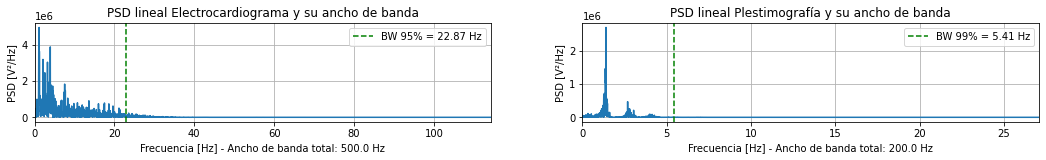

In [ ]:
def obtener_bw_pasabajos(psd,ff,porcentaje):
    pot_bw = 0; pot_tot = 0
    bw = 1; bw_anterior = 0 # en posiciones de arr
    df = ff[1] - ff[0]
    pot_tot = np.sum(psd)
    bw_tot = len(psd)
    # Nota: la potencia real deberia estar mutiplicada por df
    while pot_bw < (pot_tot * porcentaje) and bw < bw_tot:
        pot_bw += np.sum(psd[bw_anterior:bw])
        bw_anterior = bw
        bw += 1  # avanza df Hz
    
    return bw*df

bw_ecg = obtener_bw_pasabajos(psd_ecg,ff_ecg,0.95)
bw_ppg = obtener_bw_pasabajos(psd_ppg,ff_ppg,0.99)

'''
plt.figure(figsize=(18, 4))
plt.plot(ff_ppg, psd_ppg); plt.xlim(0,20)
plt.axvline(x=bw_ppg, color='green', linestyle='--', label=f'BW 90% = {bw_ppg:.2f} Hz')
plt.title("PSD lineal Electrocardiograma y su ancho de banda")
plt.xlabel("Frecuencia [Hz]"); plt.ylabel("PSD [V²/Hz]")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
'''
plt.figure(figsize=(18, 4))
plt.subplot(1,2,1); plt.plot(ff_ecg, psd_ecg); plt.xlim(0, bw_ecg*5)
plt.axvline(x=bw_ecg, color='green', linestyle='--', label=f'BW 95% = {bw_ecg:.2f} Hz')
plt.title("PSD lineal Electrocardiograma y su ancho de banda")
plt.xlabel(f"Frecuencia [Hz] - Ancho de banda total: {np.round(ff_ecg[-1])} Hz"); plt.ylabel("PSD [V²/Hz]"); plt.grid(True); plt.legend()

plt.subplot(1,2,2); plt.plot(ff_ppg, psd_ppg); plt.xlim(0, bw_ppg*5)
plt.axvline(x=bw_ppg, color='green', linestyle='--', label=f'BW 99% = {bw_ppg:.2f} Hz')
plt.title("PSD lineal Plestimografía y su ancho de banda")
plt.xlabel(f"Frecuencia [Hz] - Ancho de banda total: {np.round(ff_ppg[-1])} Hz"); plt.ylabel("PSD [V²/Hz]"); plt.grid(True); plt.legend()

plt.show()


1053.3333333333333
0.0054777637
498.3333333333333
0.000503983
6234.666666666666
0.004601433


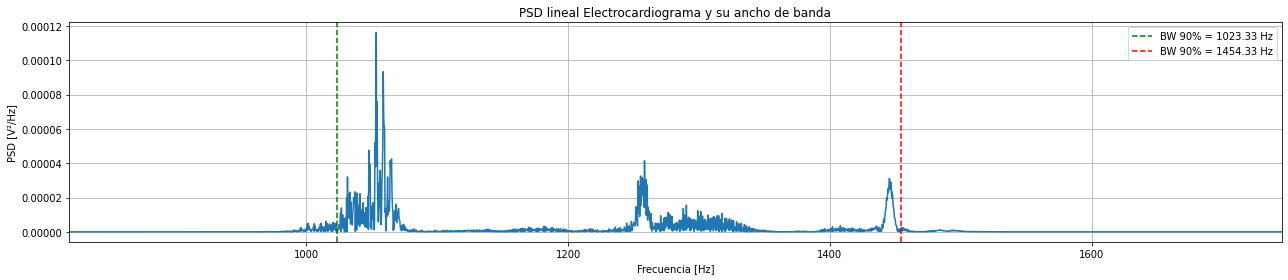

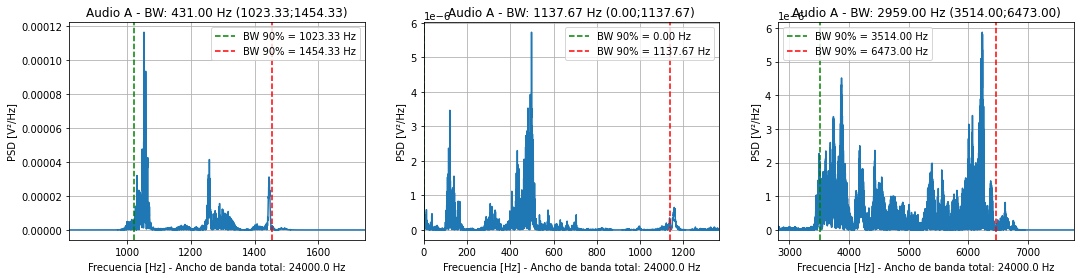

In [ ]:
def obtener_bw_pasabanda(psd,ff,porcentaje):
    pot_izq=0;pot_der=0;pot_tot = 0
    origen = np.argmax(psd) # Indice de maxima potencia (lo tomo como punto de partida para el bw)
    ind_izq = origen-1; ind_der = origen+1
    df = ff[1] - ff[0]
    pot_tot = np.sum(psd)
    bw_tot = len(psd)
    
    dt_izq = 0; dt_der = 0
    # Nota: la potencia real deberia estar mutiplicada por df
    while (pot_izq+pot_der) < (pot_tot * porcentaje) and ind_der < bw_tot:
        pot_izq = np.sum(psd[ind_izq:origen])
        pot_der = np.sum(psd[origen:ind_der])

        dt_izq = np.sum(psd[ind_izq:ind_izq+1])
        dt_der = np.sum(psd[ind_der-1:ind_der])
        if(dt_izq > dt_der): # Si hay mas potencia por la derecha, sigo explayando mi bw para la derecha
            ind_izq -= 1
        elif(dt_der > dt_izq): # Si hay mas potencia por la izquierda, sigo explayando mi bw para la izquierda
            ind_der += 1
        else:           # En el caso de que haya igual potencia en ambos lados, aumento mi bw para ambos lados
            ind_der += 1
            ind_izq -= 1
    print(origen*df)
    print(pot_tot)
    return (ind_izq)*df, (ind_der)*df

lim_izq_a,lim_der_a = obtener_bw_pasabanda(psd_wav_A,ff_wav_A,0.9)
lim_izq_b,lim_der_b = obtener_bw_pasabanda(psd_wav_B,ff_wav_B,0.9)
lim_izq_c,lim_der_c = obtener_bw_pasabanda(psd_wav_C,ff_wav_C,0.9)

plt.figure(figsize=(18, 4))
plt.plot(ff_wav_A, psd_wav_A); plt.xlim(a*0.8, b*1.2)
plt.axvline(x=lim_izq_a, color='green', linestyle='--', label=f'BW 90% = {lim_izq_a:.2f} Hz')
plt.axvline(x=lim_der_a, color='red', linestyle='--', label=f'BW 90% = {lim_der_a:.2f} Hz')
plt.title("PSD lineal Electrocardiograma y su ancho de banda")
plt.xlabel("Frecuencia [Hz]"); plt.ylabel("PSD [V²/Hz]")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


plt.figure(figsize=(18, 4))
plt.subplot(1,3,1); plt.plot(ff_wav_A, psd_wav_A); plt.xlim(lim_izq_a*0.8, lim_der_a*1.2)
plt.axvline(x=lim_izq_a, color='green', linestyle='--', label=f'BW 90% = {lim_izq_a:.2f} Hz')
plt.axvline(x=lim_der_a, color='red', linestyle='--', label=f'BW 90% = {lim_der_a:.2f} Hz')
plt.title(f"Audio A - BW: {lim_der_a-lim_izq_a:.2f} Hz ({lim_izq_a:.2f};{lim_der_a:.2f})")
plt.xlabel(f"Frecuencia [Hz] - Ancho de banda total: {np.round(ff_wav_A[-1])} Hz"); plt.ylabel("PSD [V²/Hz]"); plt.grid(True); plt.legend()

plt.subplot(1,3,2); plt.plot(ff_wav_B, psd_wav_B); plt.xlim(lim_izq_b*0.8, lim_der_b*1.2)
plt.axvline(x=lim_izq_b, color='green', linestyle='--', label=f'BW 90% = {lim_izq_b:.2f} Hz')
plt.axvline(x=lim_der_b, color='red', linestyle='--', label=f'BW 90% = {lim_der_b:.2f} Hz')
plt.title(f"Audio B - BW: {lim_der_b-lim_izq_b:.2f} Hz ({lim_izq_b:.2f};{lim_der_b:.2f})")
plt.xlabel(f"Frecuencia [Hz] - Ancho de banda total: {np.round(ff_wav_B[-1])} Hz"); plt.ylabel("PSD [V²/Hz]"); plt.grid(True); plt.legend()

plt.subplot(1,3,3); plt.plot(ff_wav_C, psd_wav_C); plt.xlim(lim_izq_c*0.8, lim_der_c*1.2)
plt.axvline(x=lim_izq_c, color='green', linestyle='--', label=f'BW 90% = {lim_izq_c:.2f} Hz')
plt.axvline(x=lim_der_c, color='red', linestyle='--', label=f'BW 90% = {lim_der_c:.2f} Hz')
plt.title(f"Audio C - BW: {lim_der_c-lim_izq_c:.2f} Hz ({lim_izq_c:.2f};{lim_der_c:.2f})")
plt.xlabel(f"Frecuencia [Hz] - Ancho de banda total: {np.round(ff_wav_C[-1])} Hz"); plt.ylabel("PSD [V²/Hz]"); plt.grid(True); plt.legend()
plt.show()

Despues de ventanear por una ventana rectangular para filtrar el ancho de banda que me interesa, ventaneo con blackmanwelch para "degradar" mis frecuencias de interes, es decir, las atenuo en los extremos de mi ancho de banda, lo cual muy probablemente se acerque mas al espectro "real" sin el ruido introducido por el sensor.